In [1]:
import numpy as np
import pandas as pd
import xarray as xr

import os
from glob import glob

import matplotlib.pyplot as plt

import histlib.matchup as match
import histlib.diagnosis as diag
from histlib.cstes import labels, zarr_dir, matchup_dir, var
from histlib.matchup import _data_var, _stress_var, _aviso_var

from xhistogram.xarray import histogram


import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.geodesic as cgeo
crs = ccrs.PlateCarree()
import cmocean.cm as cm


/home1/datahome/mdemol/.miniconda3/envs/histenv2/lib/python3.9/site-packages/dask/config.py:742: FutureWarning: Dask configuration key 'distributed.scheduler.transition-log-length' has been deprecated; please use 'distributed.admin.low-level-log-length' instead
  warnings.warn(
/home1/datahome/mdemol/.miniconda3/envs/histenv2/lib/python3.9/site-packages/dask/config.py:742: FutureWarning: Dask configuration key 'distributed.comm.recent-messages-log-length' has been deprecated; please use 'distributed.admin.low-level-log-length' instead
  warnings.warn(


In [2]:
l = labels[0]

In [4]:
if True:
    from dask.distributed import Client
    from dask_jobqueue import PBSCluster
    #cluster = PBSCluster(cores=56, processes=28, walltime='04:00:00')
    #cluster = PBSCluster(cores=7, processes=7, walltime='04:00:00')
    cluster = PBSCluster(cores=28, processes=28, walltime='08:00:00')
    w = cluster.scale(jobs=1)
else:
    from dask.distributed import Client, LocalCluster
    cluster = LocalCluster()

client = Client(cluster)
client

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: http://10.148.0.50:8787/status,
Dashboard: http://10.148.0.50:8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.148.0.50:42389,Workers: 0
Dashboard: http://10.148.0.50:8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


## IMPORT DATA, build dataset
We choose to get only erastar wind term, and we reject PEACHY data, and we select only deltaT<1H

In [5]:
dt = 10*60
dl = 5*1e3

# Test 1 label

In [6]:
def bin_dist_ms(dsm, l, dl):
    dsm = match.add_except_sum(dsm) 
    dsm = dsm.drop(['lon', 'lat'])**2
    dist_bin = np.arange(0, 200000, dl)
    dist_labels = dist_bin+dl/2
    dist_labels = dist_labels[:-1]
    dsd = dsm.groupby_bins("alti___distance", dist_bin, labels=dist_labels).mean()
    dsd['nb_coloc_bin'] = dsm.drifter_acc_x_0.groupby_bins("alti___distance", dist_bin, labels=dist_labels).count()
    dsd['drifter_sat_year']=l
    dsd = dsd.expand_dims('drifter_sat_year')
    dsd = dsd.set_coords('drifter_sat_year')
    return dsd
    
def bin_time_ms(dsm, l, dl):
    dsm = match.add_except_sum(dsm) 
    dsm = dsm.drop(['lon', 'lat'])**2
    time_bin = np.arange(0, 3*3600, dt)
    time_labels = time_bin+dt/2
    time_labels = time_labels[:-1]
    dsd = dsm.groupby_bins("alti___time_difference", time_bin, labels=time_labels).mean()
    dsd['nb_coloc_bin'] = dsm.drifter_acc_x_0.groupby_bins("alti___time_difference", time_bin, labels=time_labels).count()
    dsd['drifter_sat_year']=l
    dsd = dsd.expand_dims('drifter_sat_year')
    dsd = dsd.set_coords('drifter_sat_year')
    return dsd
    
dsm = xr.open_dataset(os.path.join(matchup_dir, f'matchup_{l}.zarr'))[var+['drogue_status', 'alti___distance', 'alti___time_difference']].dropna('obs').chunk({'obs':500})
dsd = bin_dist_ms(dsm, labels[0], 5e3)
dst = bin_time_ms(dsm, labels[0], 20*60)

In [7]:
def bin_dist_ms(ds,l, dl):
    dsm = match.add_except_sum(ds)   
    dsm = dsm.reset_coords(['lon', 'lat', 'time']).drop(['id_comb', 'time'])
    dfm = dsm.to_dask_dataframe().set_index('obs')
    dfm["distbin"] = (dfm.alti___distance // dl) * dl
    #ms
    d2 = dfm.drop(['lon', 'lat', 'distbin'], axis=1)**2
    dd = dfm[['distbin']].merge(d2)
    dd = dd.groupby(["distbin"]).mean()
    #count
    dnb = dfm.reset_index()[['obs', 'distbin']].groupby(["distbin"]).count().obs.compute().to_xarray()
    dsms = dd.compute().to_xarray()
    #attrs
    for v in list(dsms.variables) :
        if v in ds :
            dsms[v].attrs = ds[v].attrs
    #merge
    dso = xr.merge([dsms, dnb.rename('nb_coloc_bin')])
    dso['drifter_sat_year']=l
    dso = dso.expand_dims('drifter_sat_year')
    dso = dso.set_coords('drifter_sat_year')
    # center lon, lat bins + reindex to have same for all
    dist_bins = np.arange(0, 200e3, dl)
    dso = dso.reindex({'distbin':dist_bins})
    dso['distbin'] = dso['distbin']+dl/2

    return dso
    
def bin_time_ms(ds,l, dt):
    dsm = match.add_except_sum(ds)   
    dsm = dsm.reset_coords(['lon', 'lat', 'time']).drop(['id_comb', 'time'])
    dfm = dsm.to_dask_dataframe().set_index('obs')
    dfm["timebin"] = (dfm.alti___time_difference // dt) * dt
    #ms
    d2 = dfm.drop(['lon', 'lat', 'timebin'], axis=1)**2
    dd = dfm[['timebin']].merge(d2)
    dd = dd.groupby(["timebin"]).mean()
    #count
    dnb = dfm.reset_index()[['obs', 'timebin']].groupby(["timebin"]).count().obs.compute().to_xarray()
    dsms = dd.compute().to_xarray()
    #attrs
    for v in list(dsms.variables) :
        if v in ds :
            dsms[v].attrs = ds[v].attrs
    #merge
    dso = xr.merge([dsms, dnb.rename('nb_coloc_bin')])
    dso['drifter_sat_year']=l
    dso = dso.expand_dims('drifter_sat_year')
    dso = dso.set_coords('drifter_sat_year')
    # center lon, lat bins + reindex to have same for all
    time_bins = np.arange(0, 3*3600, dt)
    dso = dso.reindex({'timebin':time_bins})
    dso['timebin'] = dso['timebin']+dt/2

    return dso
    
dsm = xr.open_dataset(os.path.join(matchup_dir, f'matchup_{l}.zarr'))[var+['drogue_status', 'alti___distance', 'alti___time_difference']].dropna('obs').chunk({'obs':500})
dsd = bin_dist_ms(dsm, labels[0], 5e3)
dst = bin_time_ms(dsm, labels[0], 20*60)

In [8]:
dsd

<xarray.Dataset>
Dimensions:                                                                (
                                                                            distbin: 40,
                                                                            drifter_sat_year: 1)
Coordinates:
  * distbin                                                                (distbin) float64 ...
  * drifter_sat_year                                                       (drifter_sat_year) <U16 ...
Data variables: (12/437)
    alti___distance                                                        (drifter_sat_year, distbin) float64 ...
    alti___time_difference                                                 (drifter_sat_year, distbin) float64 ...
    e5_cstrio_z0_alti_wd_x                                                 (drifter_sat_year, distbin) float64 ...
    e5_cstrio_z0_drifter_wd_x                                              (drifter_sat_year, distbin) float64 ...
    e5_cstrio_z15_alti_wd_x                                                (drifter_sat_year, distbin) float64 ...
    e5_cstrio_z15_drifter_wd_x                                             (drifter_sat_year, distbin) float64 ...
    ...                                                                     ...
    sum_aviso__0__adt__es_cstrio_z15__drifter_y                            (drifter_sat_year, distbin) float64 ...
    sum_aviso__0__sla__e5_cstrio_z0__drifter_y                             (drifter_sat_year, distbin) float64 ...
    sum_aviso__0__sla__e5_cstrio_z15__drifter_y                            (drifter_sat_year, distbin) float64 ...
    sum_aviso__0__sla__es_cstrio_z0__drifter_y                             (drifter_sat_year, distbin) float64 ...
    sum_aviso__0__sla__es_cstrio_z15__drifter_y                            (drifter_sat_year, distbin) float64 ...
    nb_coloc_bin                                                           (drifter_sat_year, distbin) int64 ...

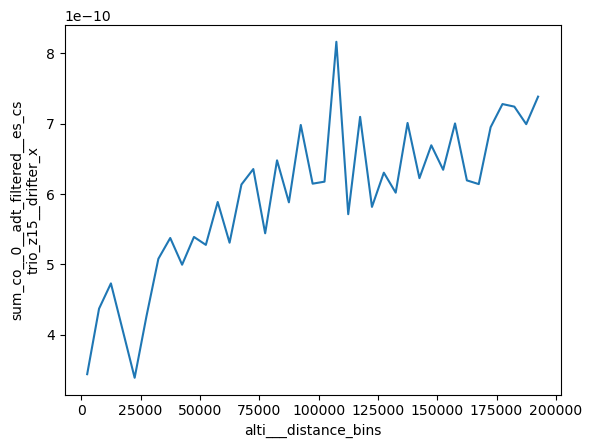

In [51]:
id_aviso = 'aviso__0__adt__es_cstrio_z15__alti_x'
id_co = 'co__0__adt_filtered__es_cstrio_z15__drifter_x'
dsd['sum_'+id_co].plot()

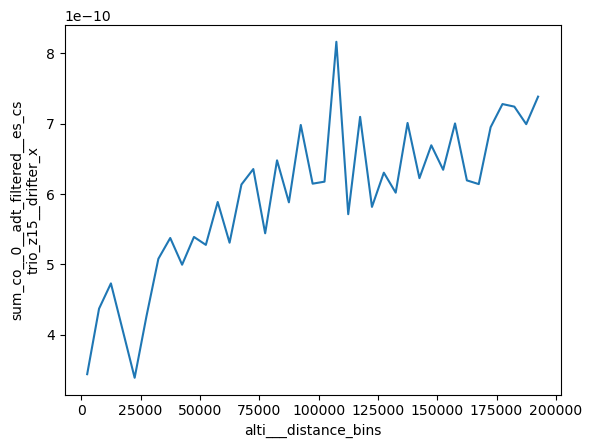

In [51]:
id_aviso = 'aviso__0__adt__es_cstrio_z15__alti_x'
id_co = 'co__0__adt_filtered__es_cstrio_z15__drifter_x'
dsd['sum_'+id_co].plot()

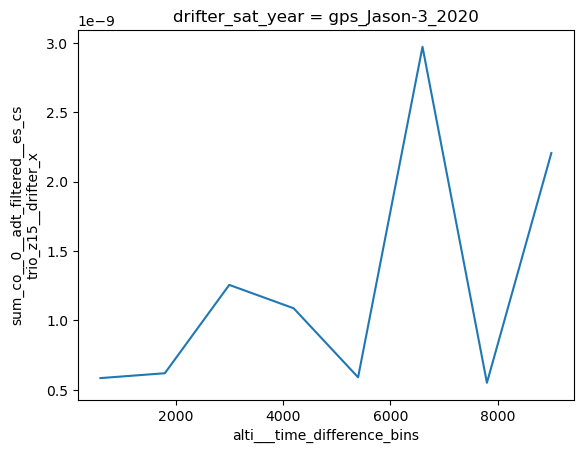

In [8]:
id_aviso = 'aviso__0__adt__es_cstrio_z15__alti_x'
id_co = 'co__0__adt_filtered__es_cstrio_z15__drifter_x'
dst['sum_'+id_co].plot()

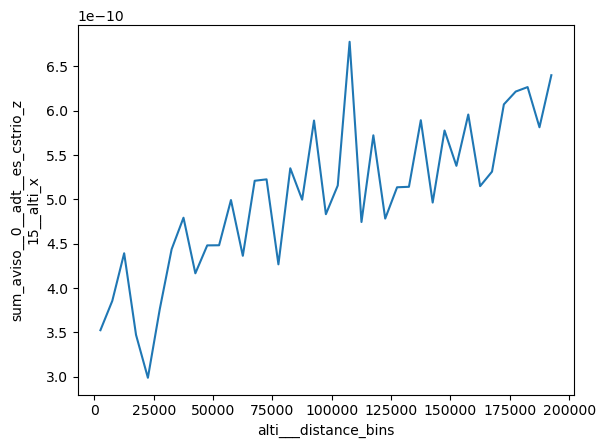

In [52]:
ds['sum_'+id_aviso].plot()

____________

In [10]:
cluster.close()